# Libraries

In [136]:
import os
import datetime
from math import sqrt
import itertools

# visualisation
import numpy as np
import pandas as pd
import missingno as mno
from scipy import signal
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# statsmodel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Meta-data 

- ``global_active_power``: The total active power consumed by the household (kilowatts).
- ``global_reactive_power``: The total reactive power consumed by the household (kilowatts).
- ``voltage``: Average voltage (volts).
- ``global_intensity``: Average current intensity (amps).
- ``sub_metering_1``: Active energy for kitchen (watt-hours of active energy).
- ``sub_metering_2``: Active energy for laundry (watt-hours of active energy).
- ``sub_metering_3``: Active energy for climate control systems (watt-hours of active energy)

In general terms, the <b>active energy</b> is the real power consumed by the household, whereas the reactive energy is the unused power in the lines.

# Data fetching

**Stop and think**   
We should not forget to specify some parameters to ensure the data is loaded correctly:

- Specify the separate between columns as a semicolon (sep=’;’)
- Specify that line 0 has the names for the columns (header=0)
- Specify that we have lots of RAM to avoid a warning that we are loading the data as an array of objects instead of an array of numbers, because of the ‘?’ values for missing data (low_memory=False).
- Specify that it is okay for Pandas to try to infer the date-time format when parsing dates, which is way faster (infer_datetime_format=True)
- Specify that we would like to parse the date and time columns together as a new column called ‘datetime’ (parse_dates={‘datetime’:[0,1]})
- Specify that we would like our new ‘datetime’ column to be the index for the DataFrame (index_col=[‘datetime’]).

In [6]:
# define dataset path
datapath="../data/raw/household_unique/household_power_consumption.txt"

In [80]:
# import / read dateset file
ts_house = pd.read_csv(datapath, sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# Data scrubbing

In [17]:
# dataset overview
ts_house.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [107]:
# renaming columns for better readability
ts_house.columns = ts_house.columns.str.lower()

In [10]:
# dataset summary
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


**Stop and think**     
We need to convert all features instances into float64 before going further through scrubbing, and replace '?' missing values into 'NaNs value as well.

In [90]:
# missing value marking
ts_house.replace('?', np.NaN, inplace=True)

In [91]:
# marking check
ts_house.values[ts_house.values == '?'].sum()

0

In [92]:
# dataset parsing from object into float64
ts_house = ts_house.astype(np.float64)

In [93]:
# parsing check 
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [110]:
# summary statistic
ts_house.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Missing values

In [95]:
# missing values check
ts_house.isnull().value_counts()

Global_active_power  Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
False                False                  False    False             False           False           False             2049280
True                 True                   True     True              True            True            True                25979
dtype: int64

In [96]:
# missing values drop
ts_house = ts_house.dropna()

In [97]:
# missing values drop check
ts_house.isnull().value_counts()

Global_active_power  Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
False                False                  False    False             False           False           False             2049280
dtype: int64

## Duplicates

In [98]:
# dataset duplicates ratio check
ts_house.duplicated().value_counts()

False    1906698
True      142582
dtype: int64

**Summary**     
- Converted object features into float64
- Replaced '?' into NaNs
- 25979 missing values drop
- 142582 duplicates not dropped

**Done**

In [79]:
# save updated dataset
ts_house.to_csv('../data/interim/household_unique/household_power_consumption.csv')

# Exploratory data analysis

In [143]:
# define plot parameters
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')

## Univariate analysis

In [128]:
# define only target feature
ts_hp = ts_house.filter(like='global_active')

### Line plot

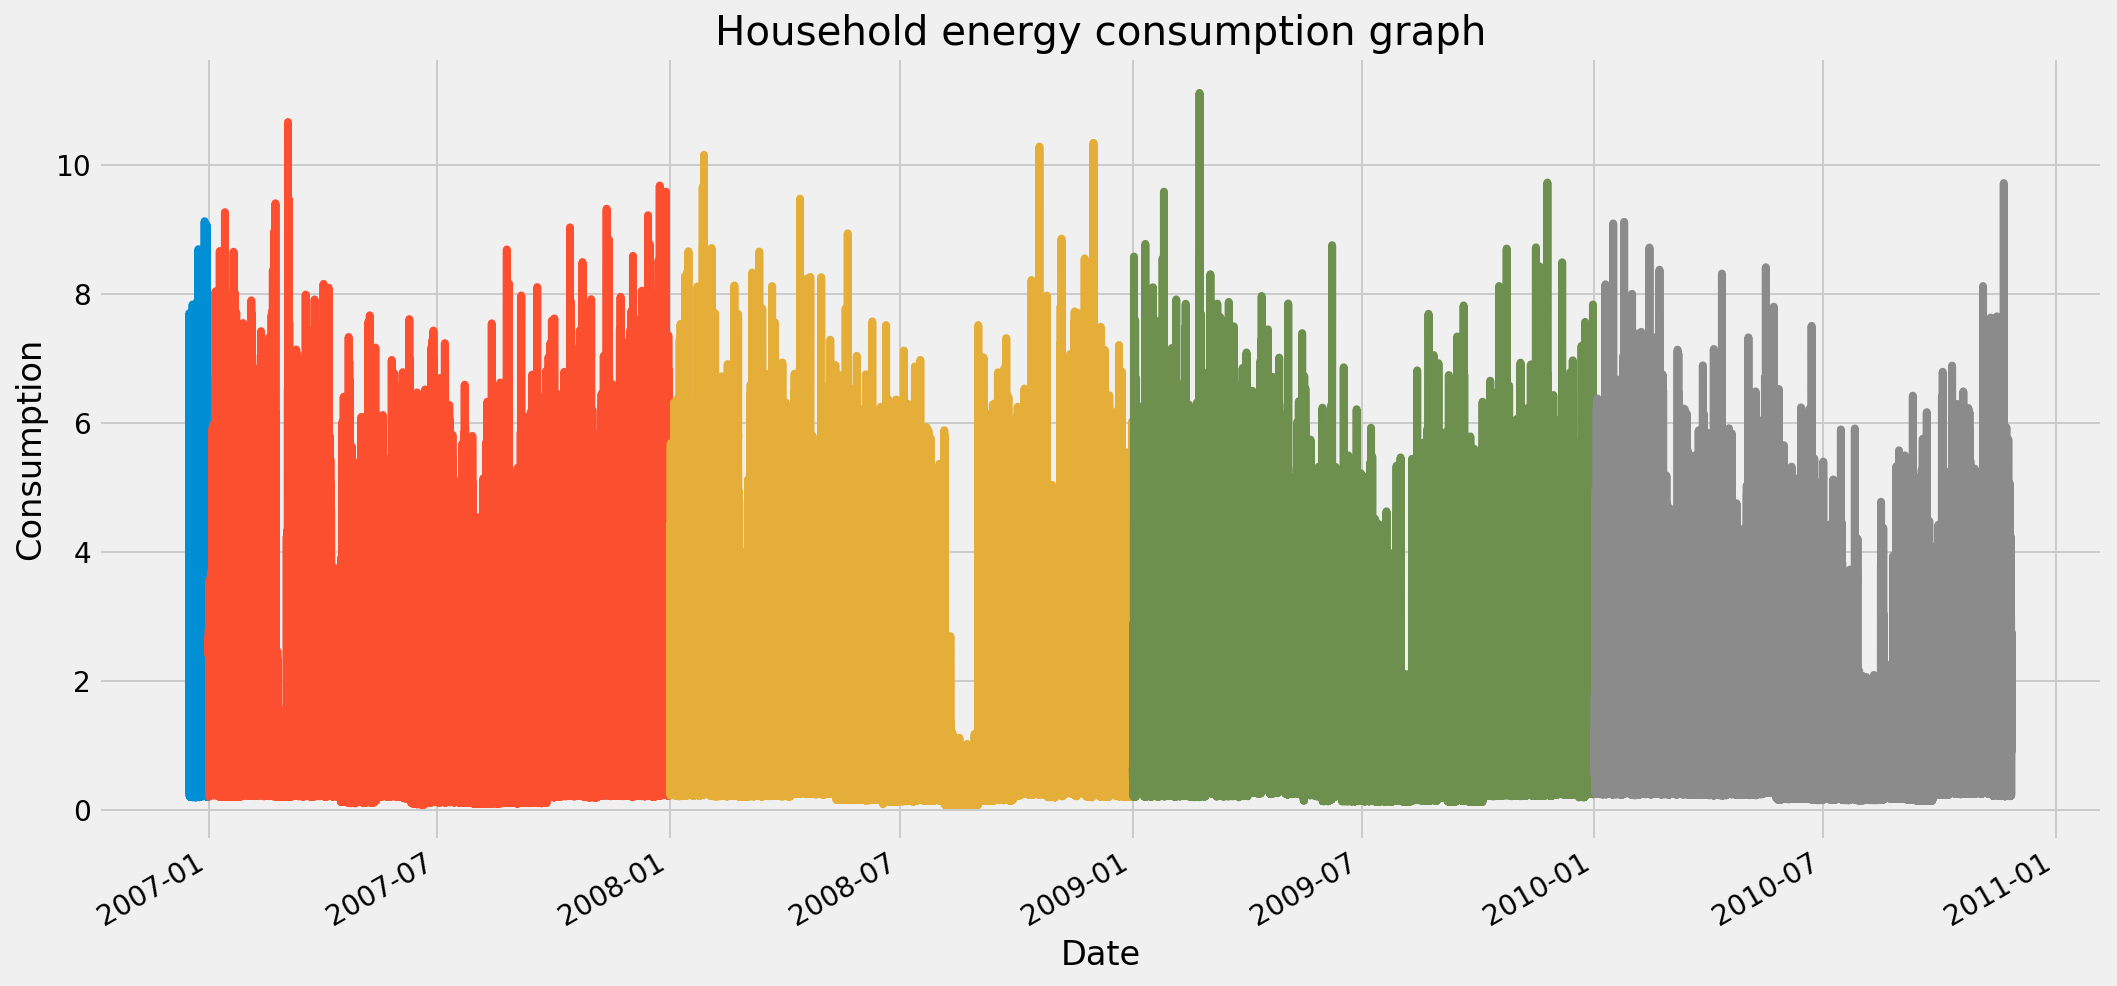

In [157]:
# features line plot
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Household energy consumption graph")
ts_hp.resample('Y').plot()
plt.show()

### Distribution plot 

<AxesSubplot:title={'center':'Household energy consumption distribution'}, xlabel='Date', ylabel='Consumption'>

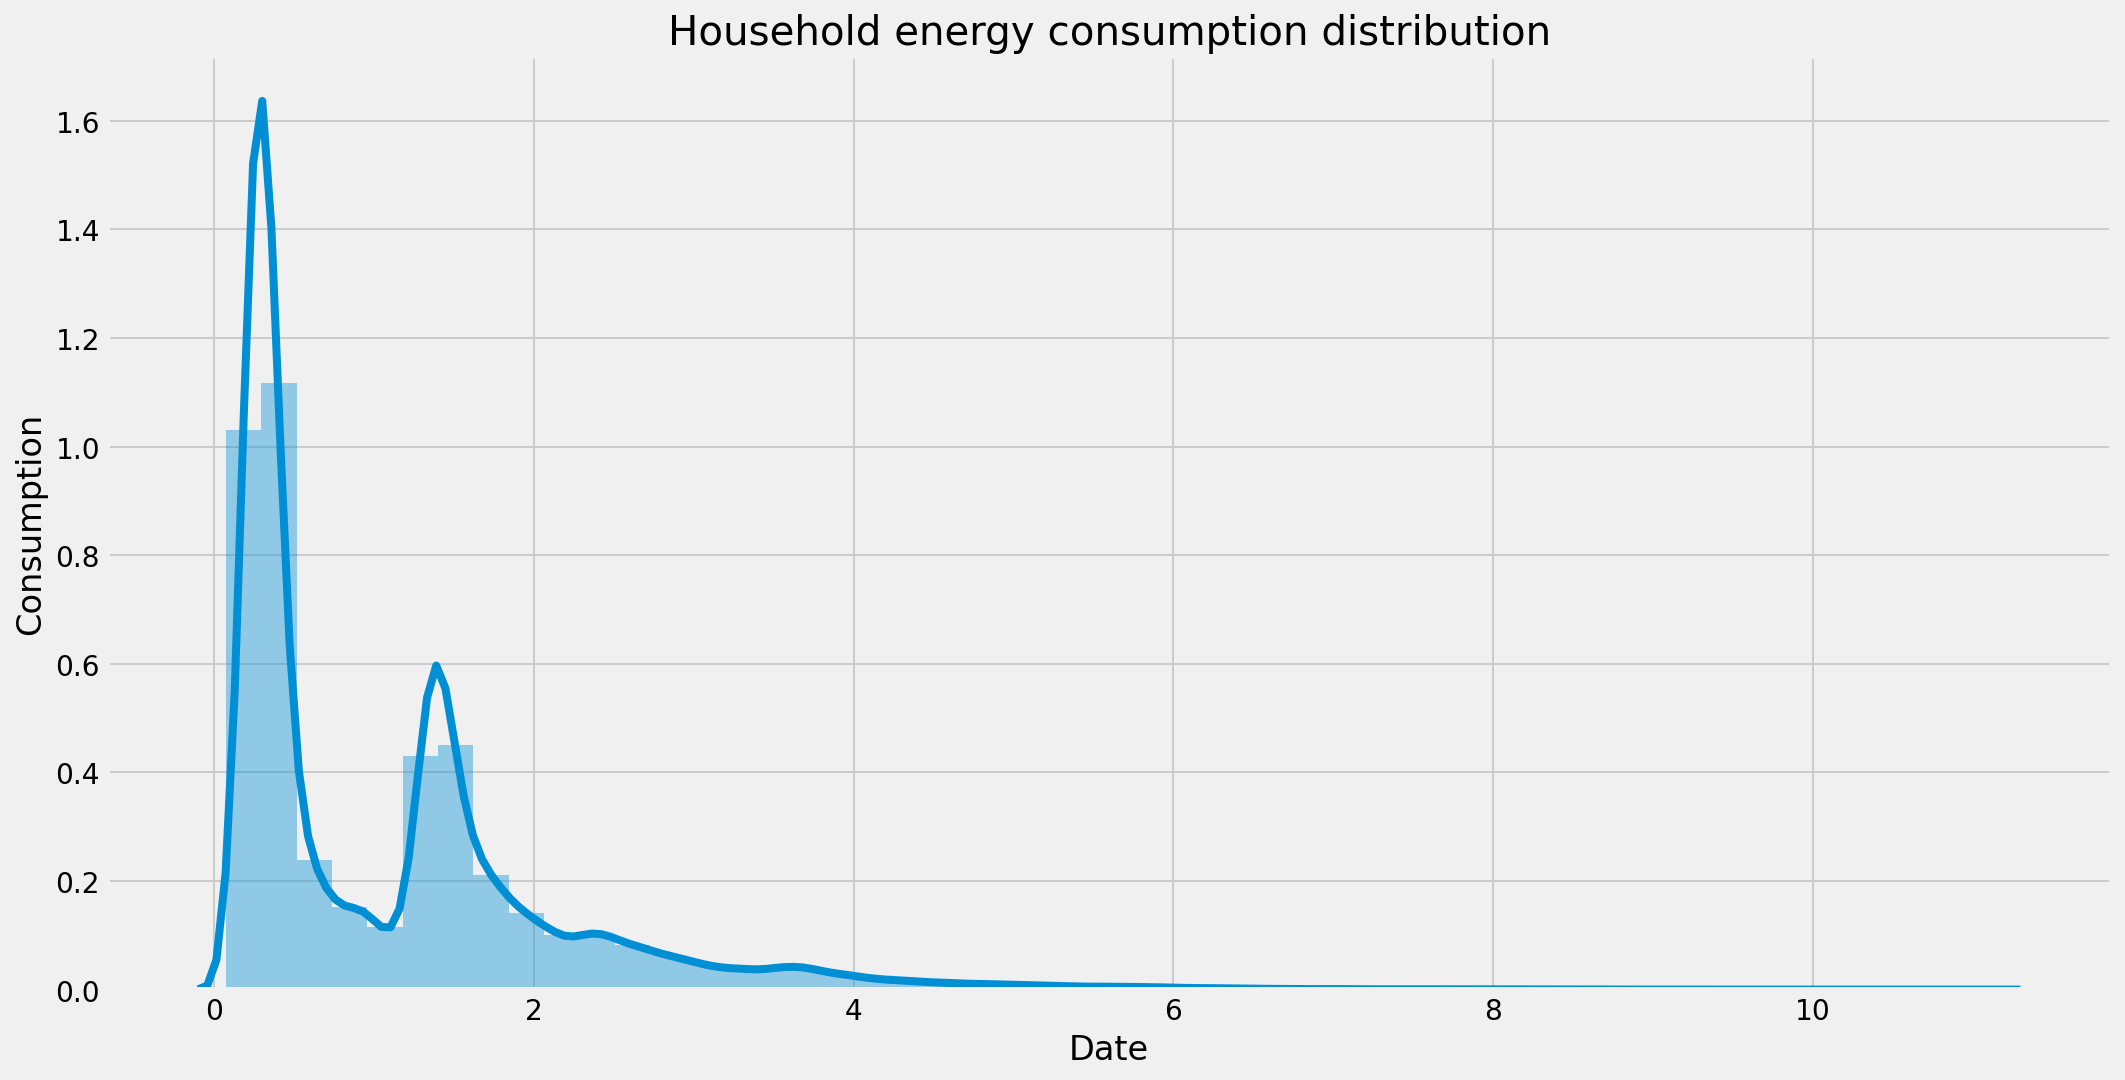

In [130]:
# distribution plot 
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Household energy consumption distribution")
sns.distplot(ts_hp)


## Components decomposition

In [ ]:
# decompose times series to distinct trend, seasonality and noise
decomposition = seasonal_decompose(ts_hp, model='additive')
fig = decomposition.plot()
fig.show()

## Stationarity 

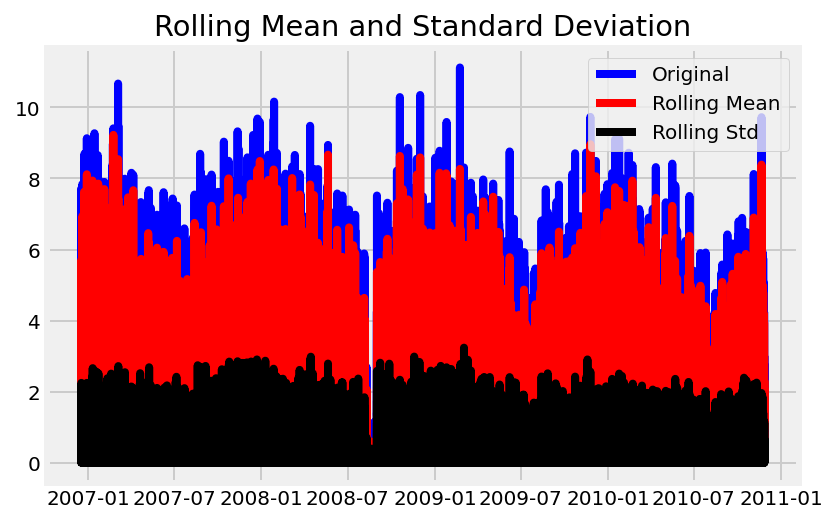

Results of dickey fuller test


KeyboardInterrupt: 

In [140]:
# instantiate ADF function 
test_stationarity(ts_hp)